### **Time Series forecasting using Tensorflow**

In [33]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf

In [34]:
data = pd.read_csv('bitcoin_data.csv', parse_dates=['Date'], index_col=['Date'])
# parse the date column and tell pandas column 1 is date-time

data.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [35]:
# reduce the data to only have date and closing price of bit-coin
bitcoin_prices = pd.DataFrame(data["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [36]:
### Train-test split
# using the dataframe of bit-coin prices
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

train_percent = 80
split_size = int(train_percent*0.01*len(timesteps))
X_train,y_train = timesteps[:split_size],prices[:split_size]
X_test,y_test = timesteps[split_size:],prices[split_size:]
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2229,), (558,), (2229,), (558,))

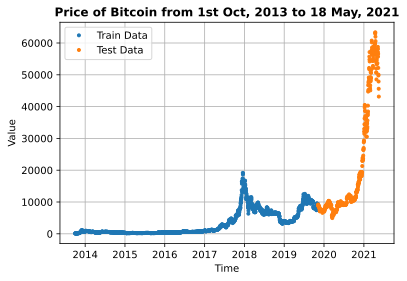

In [37]:
# visualizing data:
plt.figure(figsize=(6,4))
impf.plot_time_series(X_train,y_train,label="Train Data")
impf.plot_time_series(X_test,y_test,label='Test Data')
plt.title("Price of Bitcoin from 1st Oct, 2013 to 18 May, 2021",fontsize=12,fontweight='bold')
plt.show()

**12. Windowing our dataset**

Horizon: number of timesteps into the future we're going to predict
Window: number of timesteps we're going to use to predict horizon

Why do we window?
* We window our time series dataset to turn into a supervised learning problem
* Windowing for 1 week:
  * [0,1,2,3,4,5,6] -> [7]
  * [1,2,3,4,5,6,7] -> [8]
  * [2,3,4,5,6,7,8] -> [9]

Windowing approaches:<br><br>
<img src = 'windowing_approaches.png' width='800'></img>

* It is important to carry out chronological testing since time series ordering matters.

In [38]:
print(f"We want to use this:\n{list(prices[:7])}\nto predict:{prices[7]}")

We want to use this:
[123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795]
to predict:123.033


In [43]:
# setting up some global variables for window and horizon sizes:
HORIZON = 1 # predict next one day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

# create function to label windowed data
def get_labelled_windows(x,horizon = 1):
    '''
    Creates labels for windowed dataset

    E.g. if horizon = 1
    Input: [[0,1,2,3,4,5,6,7] 
            [1,2,3,4,5,6,7,8]
            [2,3,4,5,6,7,8,9],...]
    
    Output: [([0,1,2,3,4,5,6],[7])
    '''

    # the first colon is for all rows
    return x[:,:-horizon],x[:,-horizon:]

In [40]:
# Test out window labelling function
input = tf.expand_dims(tf.range(8),axis=0)

test_window, test_label = get_labelled_window(input)

print(f"Window: {tf.squeeze(test_window)} -> Label: {tf.squeeze(test_label)}")

Window: [0 1 2 3 4 5 6] -> Label: 7


**13. Preprocessing function to window our dataset**

* Windowing could be done using python for-loops, however for large time series, that would be quite slow.
* To speed things up, we will leverage numpy's array indexing

* Our function will:
  1. Create a window step of specific window size (e.g. [0,1,2,3,4,5,6,7])
  2. It will use numpy indexing to create a 2D array of multiple window steps:<br>
        ```[[0,1,2,3,4,5,6,7], 
            [1,2,3,4,5,6,7,8],
            [2,3,4,5,6,7,8,9],....]
        ```
  3. Uses the 2D array of multiple window steps from step 2 to index on a target series (e.g. historical price of bitcoin).
  4. Uses our get_labelled_windows() to turn window steps into windows with a specified horizon.

**REF:** https://medium.com/data-science/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [68]:
# create function to view NumPy arrays as windows
def make_windows(x,window_size = WINDOW_SIZE, horizon = HORIZON ):
    '''
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.  
    '''
    # 1. create window step of particular window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon),axis=0)

    # 2. use numpy indexing to create a 2D array of multiple windows (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis = 0).T

    # 3. index on target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. get the labelled windows
    windows,labels = get_labelled_windows(windowed_array,horizon=horizon)
    return windows,labels

full_windows,full_labels = make_windows(prices,window_size=7,horizon=1)
len(full_windows),len(full_labels),len(prices)


(2780, 2780, 2787)

In [77]:
# viewing the first k windows and labels:
k=3
for i in range(k):
    print(f"Window {i+1}: {full_windows[i-k]} ->  horizon: {full_labels[i-k]}")

Window 1: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] ->  horizon: [47885.62525472]
Window 2: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] ->  horizon: [45604.61575361]
Window 3: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] ->  horizon: [43144.47129086]


**14. Turning windows into training and test sets**

In [78]:
# make the train-test splits
def make_train_test_splits(windows,labels,test_split=0.2):
    '''
    Splits matching pair of windows and labels into train and test splits.
    '''

    split_size = int((1-test_split)*len(windows))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows,test_windows,train_labels,test_labels

In [79]:
# create train and test windows split
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(2224, 556, 2224, 556)

In [80]:
train_windows

array([[ 123.65499   ,  125.455     ,  108.58483   , ...,  121.33866   ,
         120.65533   ,  121.795     ],
       [ 125.455     ,  108.58483   ,  118.67466   , ...,  120.65533   ,
         121.795     ,  123.033     ],
       [ 108.58483   ,  118.67466   ,  121.33866   , ...,  121.795     ,
         123.033     ,  124.049     ],
       ...,
       [9225.99547934, 9131.41063031, 9197.63234462, ..., 9202.41545055,
        9369.62808116, 9326.59962378],
       [9131.41063031, 9197.63234462, 9290.89660239, ..., 9369.62808116,
        9326.59962378, 9335.75240233],
       [9197.63234462, 9290.89660239, 9202.41545055, ..., 9326.59962378,
        9335.75240233, 9226.48582088]])

***-- CONTD IN NEXT NOTEBOOK --***